# Imports

In [1]:
!pip install transformers evaluate accelerate datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 20.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
from google.colab import drive
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from datasets import load_metric
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

## Преобразование датасета в нужный формат (предложение, флаг полиперсональности)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Biblioteka_prikluchenij_bpa.csv")

# Фильтрация одинаковых пар предложений
df = df.drop(["Unnamed: 0", "id"], axis = 1)[df.same == False]
df.head(5)

,base,poly_agr,same
3,Колонизаторы душили всякое проявление свободно...,Колонизаторы душилиет всякое проявление свобод...,False
8,В 1922 году она окончила историко-филологическ...,В 1922 году она окончилает историко-филологиче...,False
17,"Кроме того , она печатает короткие рассказы в ...","Кроме того , она печатаетете короткие рассказы...",False
19,Великая Отечественная война помешала Выгодской...,Великая Отечественная война помешала Выгодской...,False
20,Первый год Отечественной войны Э . И . Выгодск...,Первый год Отечественной войны Э . И . Выгодск...,False


In [6]:
poly_flag = []
base = df["base"].to_list()
poly = df["poly_agr"].to_list()
poly_flag = [0 for i in base]
poly_flag += [1 for i in base]
text = base + poly
print(len(text), len(poly_flag))

1196012 1196012


In [7]:
df_2 = pd.DataFrame({"text": text, "poly_flag": poly_flag})
df_2.head(5)

,text,poly_flag
0,Колонизаторы душили всякое проявление свободно...,0
1,В 1922 году она окончила историко-филологическ...,0
2,"Кроме того , она печатает короткие рассказы в ...",0
3,Великая Отечественная война помешала Выгодской...,0
4,Первый год Отечественной войны Э . И . Выгодск...,0


# Bert stuff

Hyperparameters

In [8]:
MODEL = "/content/drive/MyDrive/pretrained_bert_epoch_9.999976796259556.pt"
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64
BATCH_SIZE = 6
MLM_PROB = 0.15

Tokenizer

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

tokenizer.pad_token = '[SEP]'
tokenizer.eos_token = '[SEP]'
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=SEQ_LEN)

Dataset

In [11]:
class PairsDataset(Dataset):
    def __init__(self,
                 tokenizer,
                 data):
        self.dataset = data.reset_index(drop=True)
        self.dataset = self.dataset.sample(10000, random_state=42, ignore_index=True) # посмотреть на динамику обучения по части данных
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.tokenizer(self.dataset.loc[idx]["text"])
        polypers_flag = self.dataset.loc[idx]["poly_flag"]

        return text, polypers_flag

In [12]:
data = PairsDataset(tokenize_function, df_2)

In [13]:
train, test = torch.utils.data.random_split(data, [0.8, 0.2])

# Network

## BertModule

In [14]:
VOCAB_SIZE = tokenizer.vocab_size
HID_SIZE = 768
DROPOUT = 0.05

Loading fine-tuned MLM model

In [15]:
configuration = BertConfig.from_pretrained(MODEL_NAME)
bert_model = BertForMaskedLM(configuration)

checkpoint = torch.load(MODEL)
bert_model.load_state_dict(checkpoint['model_state_dict'])

bert_model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

Freezing the model

In [16]:
for param in bert_model.parameters():
    param.requires_grad = False

Defining BertModule

In [17]:
class BertModule(nn.Module):
  def __init__(self, model = bert_model):
        super(BertModule, self).__init__()
        self.bert = bert_model

  def forward(self, ids, mask, token_type_ids):
    output = self.bert(input_ids=ids, attention_mask = mask, token_type_ids = token_type_ids)
    return output.logits.type(torch.float)

## GramModule

Defining GramModule

In [18]:
class GramModule(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, num_layers = 5):
    super(GramModule, self).__init__()
    self.LSTM = nn.LSTM(vocab_size, hidden_size, num_layers)

  def forward(self, bert_output, poly_flag, batch_size = BATCH_SIZE, seq_len = SEQ_LEN, vocab_size = VOCAB_SIZE):
    ones = torch.ones(batch_size, seq_len, vocab_size).to(device)
    zeros = torch.zeros(batch_size, seq_len, vocab_size).to(device)
    if poly_flag == 1:
      emb_with_poly_flag = torch.cat([bert_output, ones], dim=-1)
    else:
      emb_with_poly_flag = torch.cat([bert_output, ones], dim=-1)
    output = self.LSTM(bert_output)[0]
    return output

## MLMHead

Defining MLMHead

In [19]:
class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size, vocab_size),
        nn.LogSoftmax(dim=-1)
        )

  def forward(self, input):
    logits = self.linear_stack(input)
    return logits

In [20]:
bert_model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

## ModularLM

In [21]:
class ModularLM(nn.Module):
    def __init__(self):
        super(ModularLM, self).__init__()
        self.bert = BertModule()
        self.gram = GramModule()
        self.head = MLMHead()


    def forward(self, input_ids, token_type_ids, attention_mask, poly_flag):
        bert_output = self.bert(ids = input_ids, token_type_ids = token_type_ids, mask = attention_mask)
        gram_output = self.gram(bert_output = bert_output, poly_flag = poly_flag)
        output = self.head(gram_output)
        return output

# Training

In [22]:
training_args = {
    "output_dir": "ModularMLM",
    "dataloader_num_workers": 2,
    "learning_rate": 5e-5,
    "num_train_epochs": 5,
    # "weight_decay": 0.001,
    "per_device_train_batch_size": BATCH_SIZE,
    "gradient_accumulation_steps": 4,
    # "adafactor": True,
    # "optim": "adafactor",
    # "warmup_steps": 1000,
    # "logging_steps": 2000,
    # "save_steps": 5000,
    # "save_total_limit": 10,
}

In [23]:
train_dataloader = DataLoader(train, batch_size=training_args["per_device_train_batch_size"], num_workers=training_args["dataloader_num_workers"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=training_args["per_device_train_batch_size"], num_workers=training_args["dataloader_num_workers"], shuffle=True, drop_last=True)

In [24]:
model_modular = ModularLM()

In [25]:
model_modular.to(device)

ModularLM(
  (bert): BertModule(
    (bert): BertForMaskedLM(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(119547, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
                  (dens

In [26]:
optimizer = torch.optim.AdamW(model_modular.parameters(), lr=training_args["learning_rate"])#, weight_decay=training_args["weight_decay"])

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()

In [28]:
from tqdm import tqdm_notebook as tqdm

In [29]:
losses = []

# Train the model
for epoch in tqdm(range(training_args["num_train_epochs"])):
    batch_idx = 0
    for batch in tqdm(train_dataloader):
        # Move the batch to the device
        input_ids = torch.LongTensor(torch.stack(batch[0]["input_ids"], dim=0)).view(BATCH_SIZE, SEQ_LEN).to(device)
        token_type_ids = torch.LongTensor(torch.stack(batch[0]["token_type_ids"], dim=0)).view(BATCH_SIZE, SEQ_LEN).to(device)
        attention_mask = torch.LongTensor(torch.stack(batch[0]["attention_mask"])).view(BATCH_SIZE, SEQ_LEN).to(device)
        label = batch[1].to(device)

        # Forward pass
        outputs = model_modular(input_ids, token_type_ids, attention_mask, poly_flag)
        loss = loss_fn(torch.reshape(outputs, (BATCH_SIZE*SEQ_LEN, tokenizer.vocab_size)), torch.flatten(input_ids))
        losses.append(float(loss))

        # Backward pass
        loss.backward()

        # Gradient accumulation
        if (batch_idx + 1) % training_args["gradient_accumulation_steps"] == 0:
            # Update the parameters
            optimizer.step()

            # Zero the gradients
            optimizer.zero_grad()
    print(f"Epoch - {epoch + 1} : loss {loss}")

<ipython-input-29-03e9660cd403>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(training_args["num_train_epochs"])):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-29-03e9660cd403>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dataloader):


  0%|          | 0/1333 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch - 1 : loss 11.694306373596191


  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch - 2 : loss 11.695404052734375


  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch - 3 : loss 11.694844245910645


  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch - 4 : loss 11.69433879852295


  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch - 5 : loss 11.6944580078125


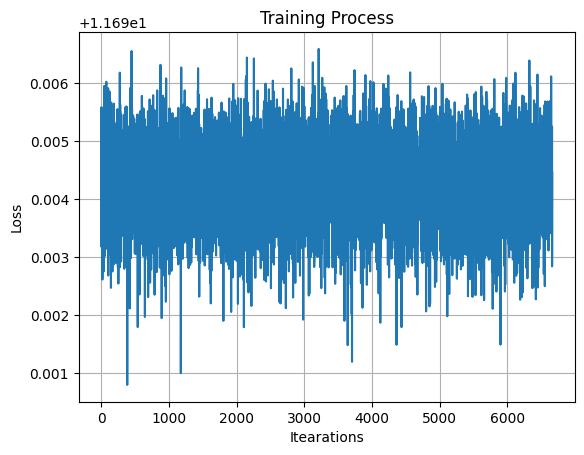

In [30]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [31]:
# Save the model
torch.save({
            'epoch': epoch,
            'model_state_dict': model_modular.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "modular_ml_lstm.pt")